# Audio Book buying prediction


### Table of Content
1. Introduction
2. Data Exploration
3. Data Cleaning and Feature Engineering
4. Model Building
5. Results and Discussion


## 1. Introduction
This project aims to predict whether a person will buy again from an audiobook vendor. By forecasting the likelyhood of a person returning, the company aims to focus their marketing efforts only on the returning customers. To aid this, we have a number of independant variables such as book length in minutes, book price, review information etc. The target variable is a binary variable which is 1 and 0 which translates to 1 being having bought in the past 6 months. This makes this problem a supervised learning problem and a binary classification problem. 

We will first load the required libraries.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer, LabelEncoder
import lightgbm as lgb
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from tabulate import tabulate
import joblib
import optuna

## 2. Data Exploration

### 2.1. Load the data and perform basic checks



The dataset is about the statistics of a list of customers who buy audiobooks. Here we will explore the dataset with some priliminary displaying. We will look at summary statistics, data types etc. The description says we only have numerical and boolian columns. First we glance at the dataset, explore how many rows and columns there are and the data types. 

In [2]:
book = pd.read_csv("Audiobooks.csv")
book[0:4]

,ID,Book_lenght_mins_avg,Book_lenght_mins_overall,Price_avg,Price_overall,review,review 10/10,completion,minutes listened,support requests,last visited minus purchase date,Targets
0,994,1620.0,1620,19.73,19.73,1,10.00,0.99,1603.8,5,92,0
1,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
3,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0



We check the data types in the data.


In [4]:
print(book.dtypes)

ID                                    int64
Book_lenght_mins_avg                float64
Book_lenght_mins_overall              int64
Price_avg                           float64
Price_overall                       float64
review                                int64
review 10/10                        float64
completion                          float64
minutes listened                    float64
support requests                      int64
last visited minus purchase date      int64
Targets                               int64
dtype: object


check the number of rows and columns

In [3]:
print("The dataset has ",book.shape[0]," rows")
print("The dataset has ",book.shape[1]," columns")

The dataset has  14084  rows
The dataset has  12  columns


In [4]:
book.describe().loc[['mean','std','min', "max"]].round(2)

,ID,Book_lenght_mins_avg,Book_lenght_mins_overall,Price_avg,Price_overall,review,review 10/10,completion,minutes listened,support requests,last visited minus purchase date,Targets
mean,16772.49,1591.28,1678.61,7.10,7.54,0.16,8.91,0.13,189.89,0.07,61.94,0.16
std,9691.81,504.34,654.84,4.93,5.56,0.37,0.64,0.24,371.08,0.47,88.21,0.37
min,2.00,216.00,216.00,3.86,3.86,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,33683.00,2160.00,7020.00,130.94,130.94,1.00,10.00,1.00,2160.00,30.00,464.00,1.00



One interesting observation is that a lot of columns relate to each other. For example, the column "minutes listened" is visibly the percentage of "completion" of the "Book_length_mins_overall". Also the "avg" columns are the average values of their corresponding aggregate columns. Therefore we could expect these columns to have inter-correlating characteristics.   

### 2.2. Check the number null values

We make sure to check if there are any null values exists in the dataset. In the following results it is clear that we do not have any null values in our dataset. This means that we do not need any method to treat for null values. However, we still need to identify the exceptional records.


In [6]:
import math
# null_df = books_pp.isnull().sum().sort_values(ascending = False)
null_df = np.isfinite(book).sum().sort_values(ascending = False)
null_df

ID                                  14084
Book_lenght_mins_avg                14084
Book_lenght_mins_overall            14084
Price_avg                           14084
Price_overall                       14084
review                              14084
review 10/10                        14084
completion                          14084
minutes listened                    14084
support requests                    14084
last visited minus purchase date    14084
Targets                             14084
dtype: int64

### 2.3. Look at the data distribution

We look at a variable's data distribution to understand the composition of the data. This will give us an indication as to what preprocessing steps are needed. For example, we will be able to identify if there are unrealistic values such as negatives that need to be treated. We will also see if the data distributions need to be scaled in this section.

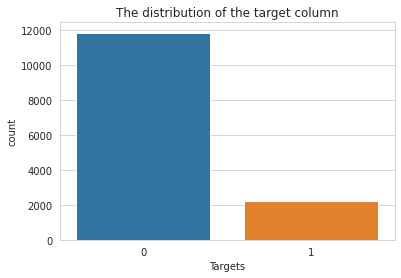

In [7]:
with sns.axes_style("whitegrid"):
    sns.countplot(x='Targets', data=book).set(title='The distribution of the target column')

Its clear that we need oversampling due to the target variable having a smaller representation

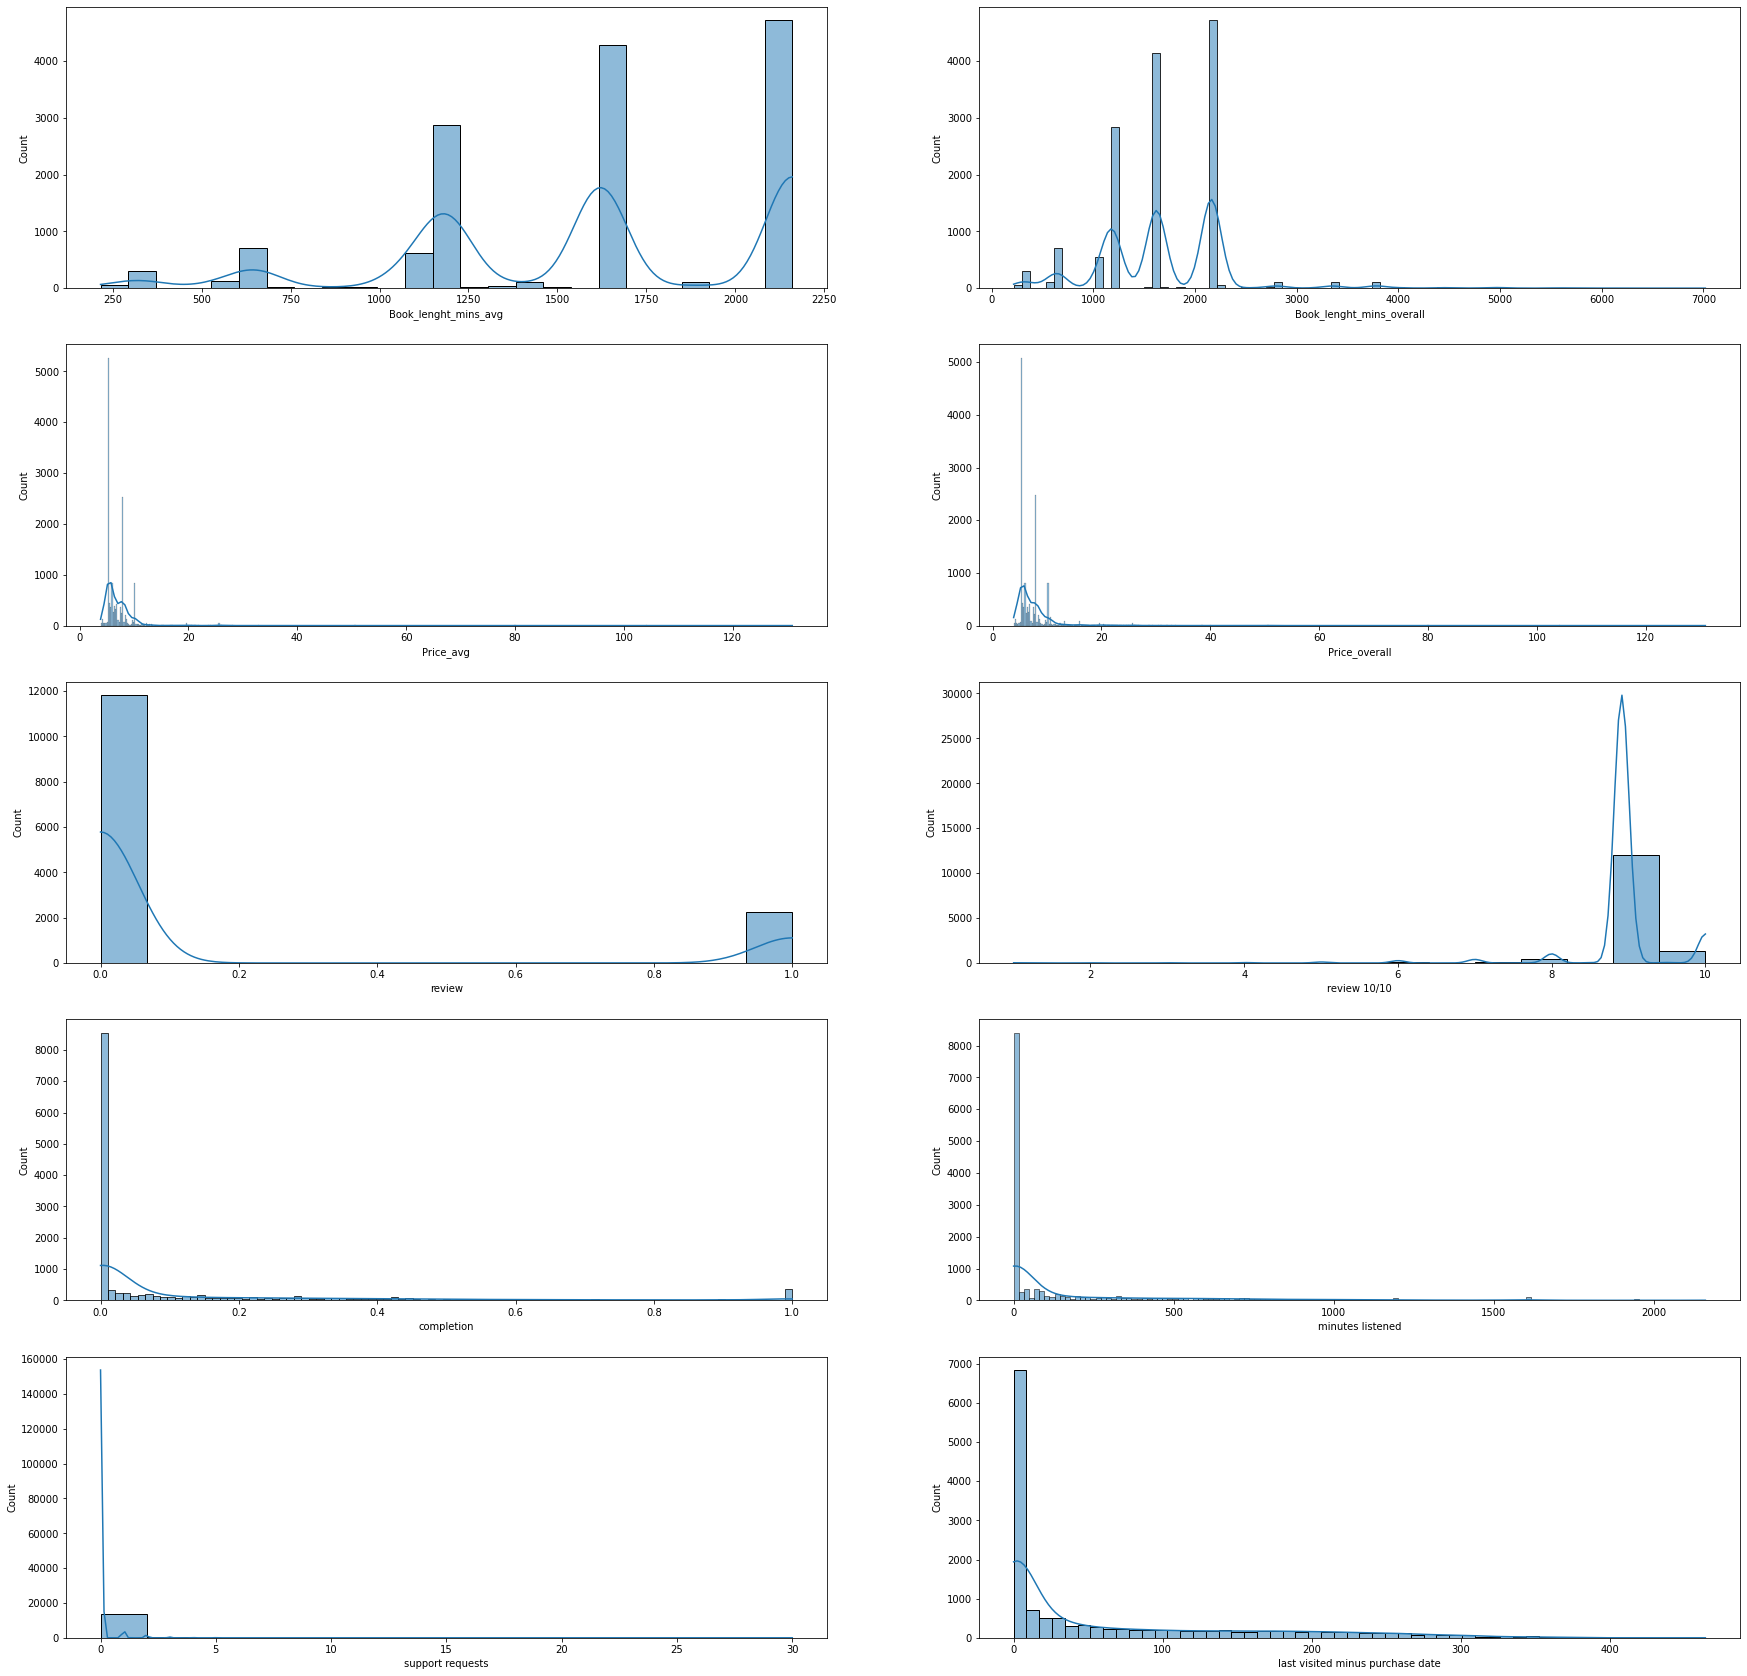

In [8]:
feature_cols = book.columns[1:11]
n_rows=5
n_cols=2

# Create the subplots

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 30), sharex=False)

for i, column in enumerate(feature_cols):
    sns.histplot(book[column],ax=axes[i//n_cols,i%n_cols], kde=True)

#### There are a few observations from the above plots:
1. We see very skewed distributions for data which is very normal in the datasets we come across in businesses.Therefore scaling may be required here. 
2. The data columns are in different scales. For example, some are in a range of 0 to 1 and others are from 0 to 2000. Therefore it is important to standardize the data. 
3. There are exceptional numbers in the dataset. For example, average prices 

### 2.4. Look at numerical features against the target column in boxplots

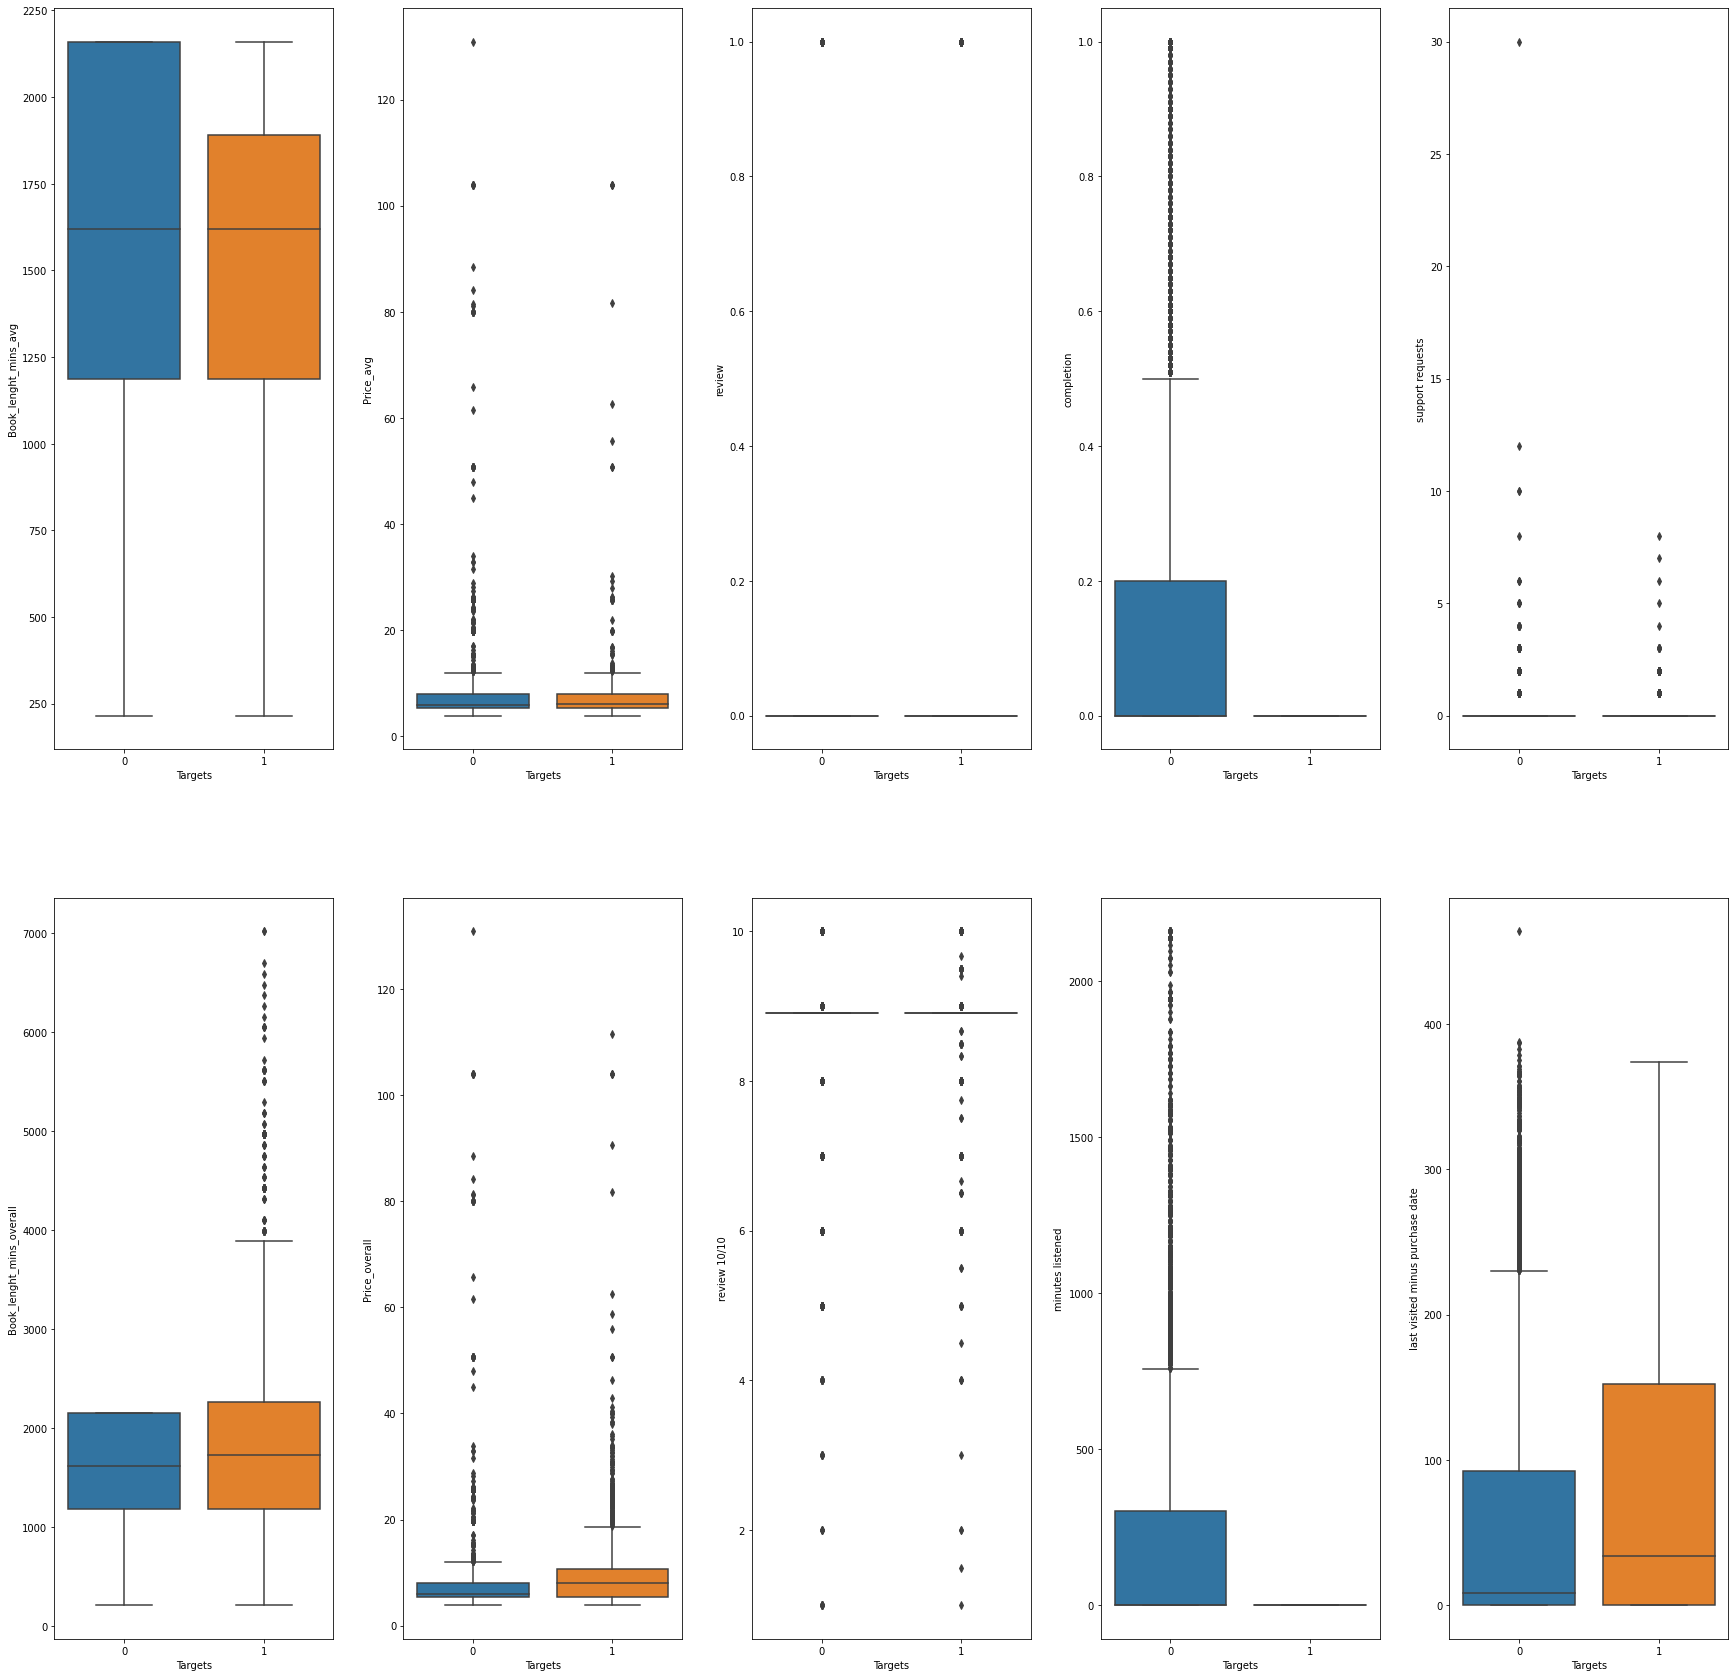

In [9]:
n_rows=5
n_cols=2

f, axes = plt.subplots(n_cols,n_rows , figsize=(30, 30), sharex=False)
plt.subplots_adjust(wspace=0.25)

for i, feature in enumerate(feature_cols):
    sns.boxplot(data=book, y = feature, x= "Targets",ax=axes[i%n_cols, i//n_cols])
#     plt.ylabel(fontsize=6)
    

Having extreme values make it very difficult to visualize the data in boxplots. We cannot extract any discernible pattern in this section.

### 2.5. Data Correlation

The data correlation will show you an early idea about what sort of a dataset we are dealing with. It will show what variables correlate heavily with our target variables and which variables could cause a collenearity problem/ redundent variables.

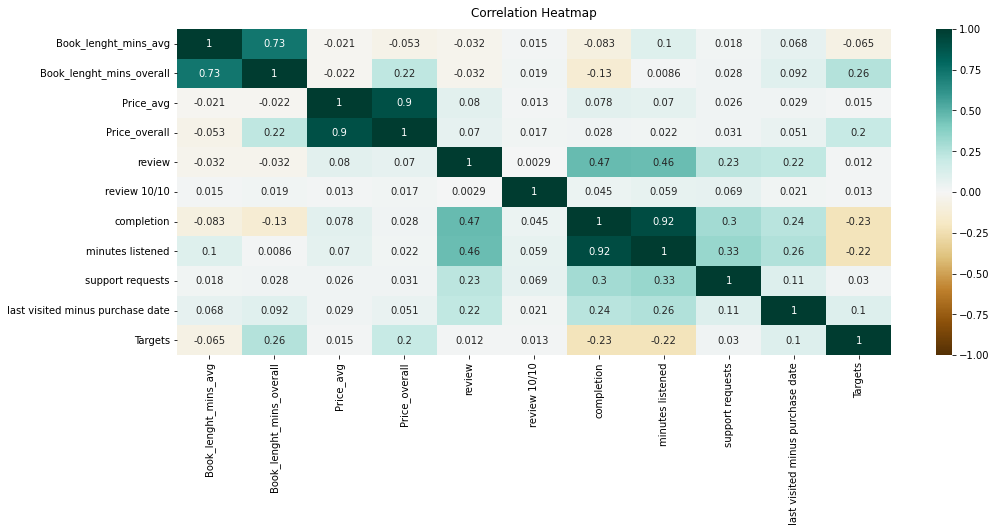

In [11]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(book[book.columns[1:]].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The correlation table provides some very interesting insights about the dataset and also about the user's behaviour.
1. It is a very intuitive dataset with a lot of information about the user behavior. For example, the higher the completion rate, the more the users tend to post reviews. The longer the users listen to the audiobooks, higher the number of support request. Interestingly, it is also seen that the completion rate has a negative correlation with the possibility of the customer returning to the platform. 

2. There are no single variable that strongly predict the customer retention. The variable that has the highest pearson correlation is the book_length_min_overall which has a 26% correlation.

3. There are some variables that have very strong correlation with each other that we can omit when running the regression. For example, minutes listened and the completion rate. We need to perform feature selection here.

## 3. Data Cleaning and Feature Engineering

In this section, we perform data cleaning, and feature creation from very basic freatures to more advanced features. We create them in the hopes of the features will help us predict the target variable better. In the data exploration section we have seen that thre are no variables that contain null values. We did not find any unrealistic numbers (such as letters appearing in numeric columns or negative numbers appearing in columns). Therefore we will not do any extensive data cleaning in this part.

First, we will check if there are repeating IDs. (if the IDs repeat, we will need to have a method to decide which record to take.)

In [25]:
len(book['ID'].drop_duplicates())==len(book)

True

We will remove the column "id" as it contains no additional information to the forecasting task.

In [47]:
books_pp = book.drop('ID', axis = 1)

Create a function to clean the heading names as they contain special characters and spaces. We make it a clean set of headers.

In [48]:
# create a function to clean column names

def clean_column_names(data):
    """
    this function performs column name cleaning
    """
    data.columns = data.columns.str.replace(' ', '_')
    data.columns = data.columns.str.replace('/', '_')
    data.columns = data.columns.str.lower()
    
    return data


books_pp = clean_column_names(books_pp)

books_pp.columns


Index(['book_lenght_mins_avg', 'book_lenght_mins_overall', 'price_avg',
       'price_overall', 'review', 'review_10_10', 'completion',
       'minutes_listened', 'support_requests',
       'last_visited_minus_purchase_date', 'targets'],
      dtype='object')

### 3.1. Feature Engineering

We create some features to better predict our target variable. Some features are business related features and some of them are synthetic features. The feature explanantions are mentioned below.

In [49]:
def standardize(df, col):
    """
    This function applies normalization
    """
    
    df[col+"_norm"]=(df[col]-df[col].mean())/df[col].std()
    
    return df


# Liking metric: minutes_listened/price_overall
books_pp['liking_metric'] = books_pp['minutes_listened']/books_pp['price_overall']

# Items purchased feature
books_pp['items_purchased'] = books_pp['book_lenght_mins_overall']/books_pp['book_lenght_mins_avg']

# Engagement metric: reviews + items_purchased + pupport_metrics
books_pp['engagement_metric'] = books_pp['review']+books_pp['items_purchased']+books_pp['support_requests']

# Minutes per dollar
books_pp['mins_per_dollar'] = books_pp['book_lenght_mins_overall']/books_pp['price_overall']

# binning the last vistited column
books_pp['last_vis_bin'] = pd.qcut(books_pp['last_visited_minus_purchase_date'].rank(method='first'), 5,labels = [1,2,3,4,5]).astype('int')

# binning the book length minutes overall
books_pp['book_lenght_mins_overall_bin'] = pd.cut(books_pp['book_lenght_mins_overall'].rank(method='first'), 5,labels = [1,2,3,4,5]).astype('int')

# books_pp['price_overall_bin'] = pd.cut(books_pp['price_overall'].rank(method='first'), 5,labels = [1,2,3,4,5])

# binning the reviews 10/10 column
books_pp['review_10_10_bin'] = pd.qcut(books_pp['review_10_10'].rank(method='first'), 5,labels = [1,2,3,4,5]).astype('int')

# completion-review feature
books_pp['completion_review'] = books_pp['completion']*books_pp['review_10_10']*+books_pp['review']

# Support request frequency metric
# books_pp['support_request_freq'] = books_pp['book_lenght_mins_overall']/books_pp['support_requests']

# review and completion rate
books_pp['review_completion'] = books_pp['review']+books_pp['completion']


books_pp=standardize(books_pp, "book_lenght_mins_avg")

### 3.2. Data Standardizing

As we observed earlier, There are some variables that are with high skewness, visually. Therefore, it is proper to convert them into a log format as it is more parsimonious to run models on that data. In the following function, we will first identify the numeric columns, then identify the columns with high skewness, thirdly, we will convert them into a log scale.

In [50]:
def convert_to_log(data, threshold):
    """
    this function converts the variables that have a skewness of over a certain threshold to log.
    """
    # collect numeric variables in the dataset
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_cols = []
    
    for i in data.columns:
        if data[i].dtype in numeric_dtypes:
            numeric_cols.append(i)
    
    # collect high-skew columns
    skew_features = books_pp[numeric_cols].apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 2]
    skew_index = high_skew.index
    
    # apply transformation 
    for k in skew_index:
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        data[[k]] = power.fit_transform(data[[k]])
    
    return data
        

books_pp = convert_to_log(books_pp, 2)
    
    

Once all the new features are created, we will visualize the correlation matrix.

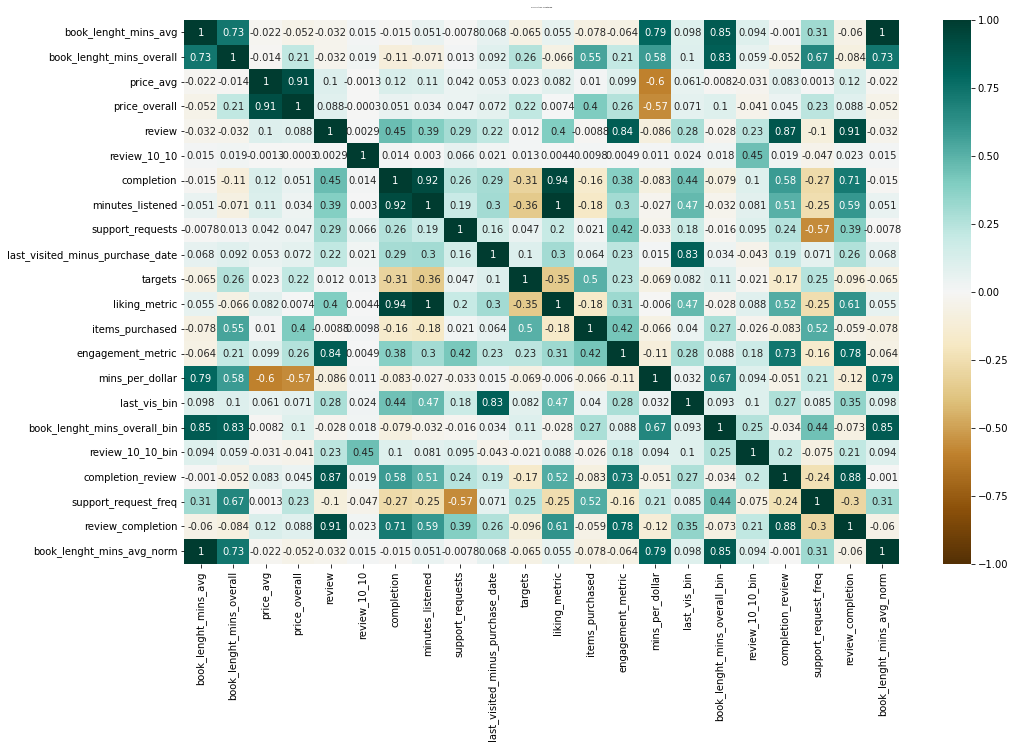

In [30]:
plt.figure(figsize=(16, 10))

heatmap = sns.heatmap(books_pp.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':2}, pad=12);

The below graph allows us to visualize the items highly correlating with the target variable very clearly.

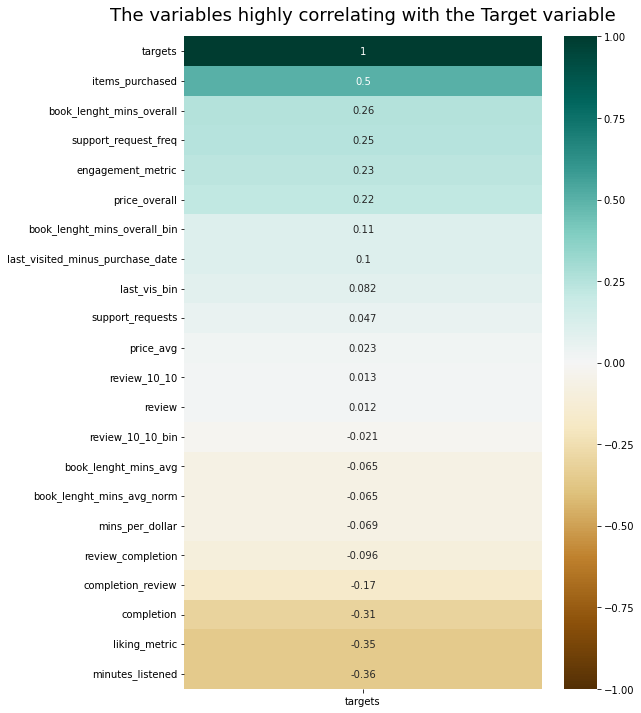

In [10]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(books_pp.corr()[['targets']].sort_values(by='targets', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('The variables highly correlating with the Target variable', fontdict={'fontsize':18}, pad=16);

### 3.3. Get dummies

We will extract the dummy variables from the categorical variables here. We have only one variable as a categorical column.

In [51]:
books_pp = pd.get_dummies(books_pp).reset_index(drop=True)


### 3.4. Define the train and test sets

We will define the train and the test sets here. We will use 20% as our test set and 80% as the train set. 

In [52]:
_test_size = 0.20
_random_seed = 1234

x = books_pp[books_pp.columns.drop('targets')]
y = books_pp['targets']
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=_test_size, random_state=_random_seed)


### 3.5. Feature selection

Now that we have created a number of features, it is important to select the features that are only relevant to predict out of all the available features. This will greatly reduce the computing requirements and make very  We will use backward feature selection, meaning that we will run a model with all the features and eleminate features that contribute least to the improvement of the model. In order to do this process we will use logistic regression as our base model. We will return 8  features of the model that provides us the best cross-validation score. 

In [53]:
x_slct = books_pp[books_pp.columns.drop('targets')]
y_slct = books_pp['targets']


logr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', n_jobs = -1, max_iter = 100)
logr.fit(x_slct,y_slct)
slect = SequentialFeatureSelector(logr,
                                  k_features = 8,
                                  forward = False,
                                  n_jobs = -1,
                                  scoring = "precision",
                                 cv = 5
                                 )
slect.fit(x_slct,y_slct)

SequentialFeatureSelector(estimator=LogisticRegression(class_weight='balanced',
                                                       n_jobs=-1),
                          forward=False, k_features=(8, 8), n_jobs=-1,
                          scoring='precision')

In [54]:
str(slect.k_feature_names_)

"('book_lenght_mins_avg', 'book_lenght_mins_overall', 'price_avg', 'price_overall', 'review', 'review_10_10', 'completion_review', 'book_lenght_mins_avg_norm')"

### Define the train and test sets

We will define the train and the test sets here. We will use 20% as our test set and 80% as the train set. 
We will also select the same set of independant variables that were identified by our feature selection exercise.

In [55]:
_test_size = 0.20
_random_seed = 1234

x = books_pp[[*slect.k_feature_names_]]
# y = books_pp['targets'].astype('bool')
y = books_pp['targets']
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=_test_size, random_state=_random_seed)

### 3.4. Oversampling 

It is important to correctly identify the customers who are likely to use the service again. As we have seen in the earlier visualizations, the dataset is not very much balanced as there are far more churn records than retained customers (11837 non churn vs 2237 retained). Hence, it is possible that the positives become difficult to classify. It will be difficult to predict who will buy. In order to counter this problem, we strive to reduce the class imbalence through oversampling. We use SMOTE library to correct the balance of our dataset. 

In [56]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from collections import Counter

# smenn = SMOTEENN()
smenn = SMOTE()
x_train_sm,y_train_sm = smenn.fit_resample(x_train,y_train)

y_train_sm.value_counts()

0    9450
1    9450
Name: targets, dtype: int64

## 4. Modelling

In the modelling section we will test out 4 advanced models. This problem is a binary classification machine learning problem. I have chosen a set of classic and more advanced algorithms of machine learning used for binary classification. All the models used here are known to perfom well in similar forecasting problems. 

1. Logistic regression
2. Gradient boosting model.
3. Random forest model.
4. LightGBM model.

For all the models we will tune parameters using cross validation accuracies. First we will set up our cross-validation platform. We perform 10 fold cross validation here in order to tune the parameters.

In [57]:
# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=_random_seed)

In [58]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    
    return params

### 4.1. Logistic Regression

First, we will try out logistic regression. Logistic regression is a popular algorithm used to predict binary classifications. It is a classic machine learning technique which is widely popular and easy to implement. 

In [60]:
def log_objective(trial):

    _max_iter = trial.suggest_int("max_iter", 50, 1000)
    
    logr = LogisticRegression(class_weight = 'balanced',
                              solver = "lbfgs",
                              n_jobs = -1,
                              max_iter = _max_iter,
                              random_state=_random_seed)


    score = cross_val_score(
        logr,x_train,y_train, cv=kfolds, scoring="accuracy"
    ).mean()
    return score

log_params = tune(log_objective)

[I 2023-01-18 09:29:56,628] A new study created in memory with name: no-name-83ccd8f5-18ce-4ccc-86d4-e6c55265a9c4
[I 2023-01-18 09:29:57,524] Trial 0 finished with value: 0.8983753374699173 and parameters: {'max_iter': 949}. Best is trial 0 with value: 0.8983753374699173.
[I 2023-01-18 09:29:58,146] Trial 1 finished with value: 0.8894104185809006 and parameters: {'max_iter': 84}. Best is trial 0 with value: 0.8983753374699173.
[I 2023-01-18 09:29:59,063] Trial 2 finished with value: 0.8983753374699173 and parameters: {'max_iter': 319}. Best is trial 0 with value: 0.8983753374699173.
[I 2023-01-18 09:29:59,953] Trial 3 finished with value: 0.8983753374699173 and parameters: {'max_iter': 461}. Best is trial 0 with value: 0.8983753374699173.
[I 2023-01-18 09:30:00,750] Trial 4 finished with value: 0.8983753374699173 and parameters: {'max_iter': 622}. Best is trial 0 with value: 0.8983753374699173.
[I 2023-01-18 09:30:01,617] Trial 5 finished with value: 0.8983753374699173 and parameters: 

Best score: 0.8983753374699173 
Optimized parameters: {'max_iter': 949}


In [61]:
logr = LogisticRegression(random_state=_random_seed, **log_params)
# logr = LogisticRegression()

logr.fit(x_train,y_train)

LogisticRegression(max_iter=949, random_state=1234)

In [62]:
y_pred_logr = logr.predict(x_test)

conmat_logr = confusion_matrix(y_test, y_pred_logr)

conmat_logr

array([[2379,   18],
       [ 261,  159]], dtype=int64)

### 4.2.  Gradient Boosting Classifier

Gradient boosting is the first algorithm we use for the binary classification problem. It is a tree based model. It develops decision trees sequentially and eash subsequent model attempts to put more focus on instances the model struggles to predict accurately. This is a powerful ensemble algorithm can be used both for classification and regression problems. 

In [63]:

def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 100)#2000
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 10)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingClassifier(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=_random_seed,
    )

    score = cross_val_score(
        gbr, x_train,y_train, cv=kfolds, scoring="accuracy"
    ).mean()
    return score

# best score =  0.916216759311648
gbr_params = tune(gbr_objective)

[I 2023-01-18 09:30:17,197] A new study created in memory with name: no-name-61950dbc-9d57-4b85-8b1d-c16537d4c0ef
[I 2023-01-18 09:30:24,814] Trial 0 finished with value: 0.9123095944687243 and parameters: {'n_estimators': 76, 'learning_rate': 0.23787937999144812, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 17}. Best is trial 0 with value: 0.9123095944687243.
[I 2023-01-18 09:30:28,724] Trial 1 finished with value: 0.9130196800320253 and parameters: {'n_estimators': 81, 'learning_rate': 0.6024943538983681, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 25}. Best is trial 1 with value: 0.9130196800320253.
[I 2023-01-18 09:30:31,393] Trial 2 finished with value: 0.9131084111766569 and parameters: {'n_estimators': 52, 'learning_rate': 0.17022551422136964, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 47}. Best is trial 2 with value: 0.9131084111766569.
[I 2023-01-18 09:30:38,765] Trial 3 

Best score: 0.913552145701898 
Optimized parameters: {'n_estimators': 54, 'learning_rate': 0.5165706203591158, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 50}


In [64]:
gbr = GradientBoostingClassifier(random_state=_random_seed, **gbr_params)
gbr.fit(x_train,y_train)

GradientBoostingClassifier(learning_rate=0.5165706203591158, max_depth=2,
                           max_features=50, min_samples_leaf=2,
                           min_samples_split=13, n_estimators=54,
                           random_state=1234)

In [65]:
y_pred_gb = gbr.predict(x_test)

conmat_gbr = confusion_matrix(y_test, y_pred_gb)

conmat_gbr


array([[2387,   10],
       [ 249,  171]], dtype=int64)

### 4.3. Random Forest Model

 We will run a random forest model secondly. Random forest model is another tree based model and an ensemble model. In summary, it builds decision trees on bootsrapped samples and combine them in order to increase the predicting power. This model can be used for regression and classification problems.

In [66]:
def randomf_objective(trial):
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    _max_depth = trial.suggest_int("max_depth", 1, 20)# ok
    _n_estimators = trial.suggest_int("n_estimators", 50, 100)# ok
    _min_samples_split = trial.suggest_int("min_samples_split", 1, 10)


    
    rf = RandomForestClassifier(                          
                             min_samples_leaf=_min_samples_leaf,
                             max_depth=_max_depth,
                             n_estimators=_n_estimators,
                             min_samples_split=_min_samples_split,
#                              random_state=_random_seed,
    )
    

    score = cross_val_score(
        rf, x_train_sm ,y_train_sm, cv=kfolds, scoring="accuracy"
    ).mean()
    
    return score

# Best score: 0.9156841360376106 
rf_params = tune(randomf_objective)

[I 2023-01-18 09:31:23,690] A new study created in memory with name: no-name-2d45abe5-8e13-4464-9009-0e960fecbe2e
[I 2023-01-18 09:31:27,140] Trial 0 finished with value: 0.7367195767195768 and parameters: {'min_samples_leaf': 5, 'max_depth': 5, 'n_estimators': 73, 'min_samples_split': 10}. Best is trial 0 with value: 0.7367195767195768.
[I 2023-01-18 09:31:31,643] Trial 1 finished with value: 0.7695238095238096 and parameters: {'min_samples_leaf': 4, 'max_depth': 16, 'n_estimators': 61, 'min_samples_split': 10}. Best is trial 1 with value: 0.7695238095238096.
[I 2023-01-18 09:31:39,227] Trial 2 finished with value: 0.7653968253968254 and parameters: {'min_samples_leaf': 7, 'max_depth': 16, 'n_estimators': 96, 'min_samples_split': 10}. Best is trial 1 with value: 0.7695238095238096.
[I 2023-01-18 09:31:44,464] Trial 3 finished with value: 0.7697354497354497 and parameters: {'min_samples_leaf': 4, 'max_depth': 20, 'n_estimators': 70, 'min_samples_split': 3}. Best is trial 3 with value: 

Best score: 0.7717460317460316 
Optimized parameters: {'min_samples_leaf': 3, 'max_depth': 16, 'n_estimators': 95, 'min_samples_split': 7}


In [67]:
rf = RandomForestClassifier(random_state=_random_seed, **rf_params)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=3, min_samples_split=7,
                       n_estimators=95, random_state=1234)

In [68]:
y_pred_rf = rf.predict(x_test)

confusion_matrix(y_test, y_pred_rf)


array([[2386,   11],
       [ 249,  171]], dtype=int64)

### 4.4. LightGBM model

LightGBM was introduced recently and it builds on the gradient boosting principal. It builds the trees leaf-wise as opposed to level-wise in Xgboost. This algorithm is popular as it is fast but at the same time can handle a large amount of data.

In [69]:

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    
    lgbr = lgb.LGBMClassifier(objective='binary',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=_random_seed,
    )
    

    score = cross_val_score(
        lgbr, x_train_sm,y_train_sm, cv=kfolds, scoring="accuracy"
    ).mean()
    return score

# Best score: 0.9673406338967385 
lgb_params = tune(lgb_objective)

[I 2023-01-18 09:32:33,955] A new study created in memory with name: no-name-2c4559a9-307b-4a76-8a8c-07389076305f
[I 2023-01-18 09:32:36,551] Trial 0 finished with value: 0.7549206349206349 and parameters: {'num_leaves': 73, 'max_depth': 3, 'learning_rate': 0.8016139753582151, 'n_estimators': 1756, 'min_child_weight': 2.4834646690623168, 'reg_alpha': 8.60879832486658, 'reg_lambda': 7.985833645295818, 'subsample': 0.5734571954502633}. Best is trial 0 with value: 0.7549206349206349.
[I 2023-01-18 09:32:38,536] Trial 1 finished with value: 0.7634391534391535 and parameters: {'num_leaves': 73, 'max_depth': 10, 'learning_rate': 0.2127362555713025, 'n_estimators': 502, 'min_child_weight': 9.721019532804474, 'reg_alpha': 6.438825201797896, 'reg_lambda': 9.296568549526416, 'subsample': 0.336427361695532}. Best is trial 1 with value: 0.7634391534391535.
[I 2023-01-18 09:32:39,969] Trial 2 finished with value: 0.762910052910053 and parameters: {'num_leaves': 96, 'max_depth': 20, 'learning_rate':

Best score: 0.7724338624338623 
Optimized parameters: {'num_leaves': 76, 'max_depth': 14, 'learning_rate': 0.5278018042729249, 'n_estimators': 793, 'min_child_weight': 6.845592287404007, 'reg_alpha': 2.2438033056580036, 'reg_lambda': 6.609653593185638, 'subsample': 0.33965195562461187}


In [70]:
lgb_params

{'num_leaves': 76,
 'max_depth': 14,
 'learning_rate': 0.5278018042729249,
 'n_estimators': 793,
 'min_child_weight': 6.845592287404007,
 'reg_alpha': 2.2438033056580036,
 'reg_lambda': 6.609653593185638,
 'subsample': 0.33965195562461187}

In [71]:
lgbr = lgb.LGBMClassifier(objective='binary', random_state=_random_seed, **lgb_params)
lgbr.fit(x_train,y_train)


LGBMClassifier(learning_rate=0.5278018042729249, max_depth=14,
               min_child_weight=6.845592287404007, n_estimators=793,
               num_leaves=76, objective='binary', random_state=1234,
               reg_alpha=2.2438033056580036, reg_lambda=6.609653593185638,
               subsample=0.33965195562461187)

In [72]:
y_pred_lgb = lgbr.predict(x_test)
conmat_lgb = confusion_matrix(y_test, y_pred_lgb)
conmat_lgb

array([[2386,   11],
       [ 249,  171]], dtype=int64)

## 5. Results and Discussion

### 5.1. Accuracy and the fitness of model

I believe that, in this usecase the most important metric is the true positive rate. Which means that, it is more important to identify the customers who are likely to return than identifying the customers who are not. Which means that, while there are many metrics to look at the accuracy of a binary classification problem, metrics such as true positive rate plays a big part. 

First, we will visually see the ROC curve. It is a very good visualization to see what we have to give up in order to identify the true positives correctly. 

In [73]:
lgb_prob = lgbr.predict_proba(x_test)[::,1]
rf_prob = rf.predict_proba(x_test)[::,1]
gbr_prob = gbr.predict_proba(x_test)[::,1]
logr_prob = logr.predict_proba(x_test)[::,1]

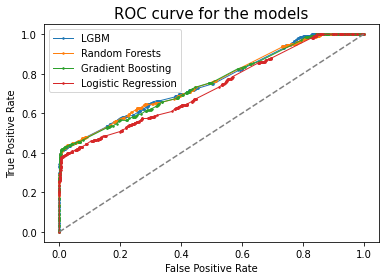

In [74]:

from sklearn.metrics import roc_curve
from matplotlib import pyplot

lr_fpr, lr_tpr, _ = roc_curve(y_test, lgb_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
gbr_fpr, gbr_tpr, _ = roc_curve(y_test, gbr_prob)
logr_fpr, logr_tpr, _ = roc_curve(y_test, logr_prob)


pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM', linewidth=1, markersize=3)
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forests', linewidth=1, markersize=3)
pyplot.plot(gbr_fpr, gbr_tpr, marker='.', label='Gradient Boosting', linewidth=1, markersize=3)
pyplot.plot(logr_fpr, logr_tpr, marker='.', label='Logistic Regression', linewidth=1, markersize=3)
pyplot.plot([0, 1], [0, 1], color = 'grey', linewidth = 1.5, linestyle='dashed')
pyplot.title("ROC curve for the models", size = 15)

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

The ROC curve shows the trade-off between true positive rate and the false positive rate. Or in other words, how much false positives we can tolerate in order to correctly identify the true positives. The 45 degree line shows the random or no-skill line. The tree-based models seem to perform very equally here. However, the logistic regression seems to be slightly less accurate than its counterparts. It looks as if we will have to look at the exact metrics to select a model.

In [75]:

def get_accuracy_scores(y_test, y_pred):
    """
    Gets the accuracy figures for models
    """
    prec = str(round(precision_score(y_test, y_pred)*100,2))+"%"
    rec = str(round(recall_score(y_test, y_pred)*100,2))+"%"
    acc = str(round(accuracy_score(y_test, y_pred)*100,2))+"%"
    
    return prec, rec, acc

lgbm_prec,lgbm_rec,lgbm_acc = get_accuracy_scores(y_test, y_pred_lgb)
rf_prec, rf_rec, rf_acc = get_accuracy_scores(y_test, y_pred_rf)
gbm_prec, gbm_rec, gbm_acc = get_accuracy_scores(y_test, y_pred_gb)
logr_prec, logr_rec, logr_acc = get_accuracy_scores(y_test, y_pred_logr)

In [76]:

print(tabulate([['1. LGBM', lgbm_prec,lgbm_rec,lgbm_acc],
                ['2. RF', rf_prec,rf_rec,rf_acc],
                ['3. GBM', gbm_prec,gbm_rec,gbm_acc],
                ['4. Logistic', logr_prec,logr_rec,logr_acc]
               ],
               headers=['Model', 'Precision','recall','Accuracy']))


Model        Precision    recall    Accuracy
-----------  -----------  --------  ----------
1. LGBM      93.96%       40.71%    90.77%
2. RF        93.96%       40.71%    90.77%
3. GBM       94.48%       40.71%    90.81%
4. Logistic  89.83%       37.86%    90.1%


The accuracy scores look very similar across the 4 different models. Logistic regression looks slightly less accurate than its counterparts in classifying the positive instances. The accuracy of all the other models seem very similar. I suggest using  any of the first 3 models listed. 

### 5.2. Feature Importances

It is important to see which variables have been most important in predicting the target variable. In total we have 22 variables. There are two instances that help us identify the important features. First, we identify 8 features that help predict the target variable the most in the feature selection section. It says that the following features were important in predicting the target variable.

In [77]:
slect.k_feature_names_

('book_lenght_mins_avg',
 'book_lenght_mins_overall',
 'price_avg',
 'price_overall',
 'review',
 'review_10_10',
 'completion_review',
 'book_lenght_mins_avg_norm')

Secondly, the feature importance plots give us a very good understanding on which features are most important to predict the target variable.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

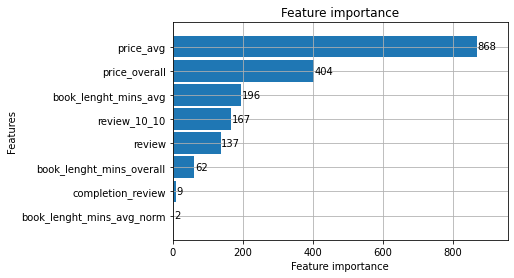

In [78]:
lgb.plot_importance(lgbr, max_num_features = 60, height=.9)

We can see that the most important variable is the mins_pre_dollar variable which was one I created. 4 variables out of 8 variables are the ones I have created in the feature engineering section. This also means how important the feature engineering step is.